In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

# class

In [2]:
class dist_plot:
    '''
    Class for generating the plot, distance between species vs evolutionary time

    Methods:
    categorize : categorize genes based on their fdr value (stabilized selection for fdr < 0.05)
    power_fit : power fit to expression distance versus time (y=a*x^k)
    linear_fit : linear fit to expression distance versus time (y=m*x+n)
    residual : calculate mean squared distance from reference species. 
               First, mean across genes. Then, calculate mean & std across replicates in species
    plot : scatter plot with error bar & fitted lines
    run : run all the methods above, and get 3 plots, total genes, genes under stabilizing selection, 
          and genes under neutral evolution.
    '''

    def __init__(self,
                 X,
                 species, 
                 dist_mat,
                 stat,
                 ref = "Human",
                 title = "distance plot"
                 ):
        '''
        Initialize class instance

        Arguments:
        X (dataframe) : RNA expression data, columns(samples) & rows(genes)
        species (list) : species to analyze
        dist_mat (dataframe) : evolutionary time difference from reference species
        stat (dataframe) : outcome of OU model containing gene_name, qvalues, thetas, var, and brownSigmas
        title (str) : title of plot
        '''
        
        self.X = X.copy()
        self.species = species
        self.stat = stat
        self.ref = ref
        self.title = title

        # extract the evolutionary time 
        self.timedata = dict(zip(dist_mat["species"],dist_mat[self.ref]))

        self.stabilized = []
        self.neutral = []
        self.res = pd.DataFrame()


    def categorize(self):
        for i, q in enumerate(self.stat["qvalues"]):
            if q < 0.05:
                self.stabilized.append(self.stat["gene_name"][i])      ## check the index of stat
            elif q > 0.05:
                self.neutral.append(self.stat["gene_name"][i])
        # stabilized selection
        self.stabilized = self.X[self.X.index.isin(self.stabilized)]
        # neutral evolution
        self.neutral = self.X[self.X.index.isin(self.neutral)]


    def f(self, t, a, k):
        # power law fitting
        return a*t**k

    def power_fit(self, mean, t):
        try:
            # curve fit
            popt, pcov = curve_fit(self.f, xdata=t, ydata=mean, p0=(1,1),maxfev=1000)
            a = popt[0]
            k = popt[1]

            # r2
            residuals = mean-self.f(t,*popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((mean-np.mean(mean))**2)
            r2 = 1-(ss_res/ss_tot)

        except RuntimeError:
            a = None
            k = None
            r2 = None
            
        return r2, a, k


    def linear_fit(self, y, x):
        # linear regression model & fit
        model = sm.OLS(y, x)
        result = model.fit()

        # coefficients
        coefficients = result.params
        r2 = result.rsquared
        m=coefficients[1]
        n=coefficients[0]

        return r2, m, n
    

    def residual(self, data):
        data = data.fillna(data.mean(axis=1)) ## column check
        col = data.columns

        # ref mean
        idx = [j for j in col if self.ref in j]    # index for reference species
        ref = data[idx].mean(axis=1)

        # mean & std across species
        mean = pd.DataFrame()
        mean_dist = {}
        std_dist = {}
        for i in self.species:
            print(i)
            idx = [j for j in col if i in j]
            for j in idx:
                mean[j] = (data[j]-ref)**2
            #if data.shape == self.X.shape:
                #self.res[i] = mean[idx].mean(axis=1)

            mean_dist[i] = np.mean(mean[idx].mean(axis=1, skipna=True))
            if len(idx) > 1:
                std_dist[i] = np.mean(mean[idx].std(axis=1, skipna=True))
            else:
                std_dist[i] = 0


        # sort mean, std, and time to get same order
        df = {}
        for s in self.species:
            df[s] = [self.timedata[s], mean_dist[s], std_dist[s]]

        df = pd.DataFrame(df)
        return df


    def plot(self, data):
        df = self.residual(data)
        print(df)

        #plt.errorbar(df.iloc[0,:], df.iloc[1,:], yerr=df.iloc[2,:], fmt='o', ecolor='b', capsize=1)
        plt.scatter(df.iloc[0,:], df.iloc[1,:])

        x = np.linspace(0, max(df.iloc[0,:])+0.1, 100)

        # linear fit
        r2_l, m, n = self.linear_fit(np.array(df.iloc[1,:]), sm.add_constant(np.array(df.iloc[0,:])))
        plt.plot(x, m*x+n, label=f'linear, r2={r2_l:.2f}')
        print("linear fit",m,n)

        # power fit
        r2_p, a, k = self.power_fit(df.iloc[1,:], df.iloc[0,:])
        plt.plot(x, a*x**(k), label = f"power, r2={r2_p:.2f}")
        print("power fit",a,k)

        for i in self.species:
            plt.annotate(i[:4], (df.iloc[0, self.species.index(i)], df.iloc[1, self.species.index(i)]), fontsize='small')

        plt.xlabel("evolutionary time")
        plt.ylabel("Mean Squared Expression Distance")
        plt.legend()
        plt.title(f"gene : {data.shape[0]}, {self.title}")
        plt.show()


    def run(self):
        # total genes
        self.plot(data=self.X)

        self.categorize()
        # stabilizing selection
        self.title = "Stabilized Selection"
        self.plot(data = self.stabilized)

        # neutral evolution
        self.title = "Neutral Evolution"
        self.plot(data = self.neutral)

    
    def compare(self):
        gene = self.X.index
        
        result = {"R2_l":np.zeros(len(gene)),"R2_p":np.zeros(len(gene)),
                  "m":np.zeros(len(gene)), "n":np.zeros(len(gene)),
                  "a":np.zeros(len(gene)), "k":np.zeros(len(gene))}


        # ref mean
        idx = [j for j in self.X.columns if self.ref in j]    # index for reference species
        ref = self.X[idx].mean(axis=1)

        # mean & std across species
        mean = pd.DataFrame()
        mean_dist = {}
        for i in self.species:
            idx = [j for j in self.X.columns if i in j]
            for j in idx:
                mean[j] = (self.X[j]-ref)**2
            #if data.shape == self.X.shape:
                #self.res[i] = mean[idx].mean(axis=1)
            mean_dist[i] = mean[idx].mean(axis=1, skipna=True)


        for i,g in enumerate(gene):
            if i%100==0:
                print(i)
            df = pd.DataFrame({
            s: [self.timedata[s], mean_dist[s][i]] for s in self.species
            })
            
            try:
                # linear fit
                result["R2_l"][i], result["m"][i], result["n"][i] = self.linear_fit(np.array(df.iloc[1,:]), sm.add_constant(np.array(df.iloc[0,:])))
                # power fit
                result["R2_p"][i], result["a"][i], result["k"][i] = self.power_fit(df.iloc[1,:], df.iloc[0,:])
            except ValueError:
                result["R2_l"][i], result["m"][i], result["n"][i] = [None, None, None]
                result["R2_p"][i], result["a"][i], result["k"][i] = [None, None, None]

        result = pd.DataFrame(result)
        result.insert(0,"gene_name",gene)
        return result

# input data

In [63]:
species = ["human", "cow", "marmoset", "dog", "armadillo",
           "gorilla", "musMusculus", "musSpretus", "musCaroli", "opossum", 
           "ferret", "rabbit", "chimp", "bonobo", "orangutan", "rhesus", 'rat']
len(species)

17

In [64]:
# check the columns 
residual = pd.read_csv("/Users/yunseong-eun/Desktop/processed_chen/subset/residual/liver.txt", delimiter="\t")
residual.set_index("Unnamed: 0", inplace=True)
residual

,human,human.1,cow,cow.1,cow.2,marmoset,marmoset.1,dog,armadillo,gorilla,...,orangutan,orangutan.1,rhesus,rhesus.1,rhesus.2,rhesus.3,rhesus.4,rat,rat.1,rat.2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NFYA,-0.114488,-0.095351,0.100424,0.034960,0.145547,0.390742,0.253350,-0.030670,-0.098209,0.170911,...,0.052878,0.040446,0.217558,0.154132,0.136322,0.063613,0.078532,-0.016821,-0.055374,0.015914
IBTK,-0.043214,0.087097,-0.007231,-0.119967,-0.315344,0.102267,0.233247,-0.170423,-0.045568,0.076010,...,-0.052926,0.000785,-0.115874,0.178527,0.224741,0.216164,0.301310,0.302895,0.256496,0.248873
IFI35,-0.046234,0.096034,-0.021202,0.099745,-0.003942,0.092818,0.439715,0.192727,-0.207007,0.131039,...,0.100317,0.204218,-0.015791,-0.122364,-0.089000,-0.329706,-0.030936,0.190825,0.095404,0.142246
TAL1,-0.140897,-0.095293,0.135039,0.306005,0.334350,0.203323,-0.149160,-0.477968,0.246713,0.076539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.038484,0.182846,0.106768
ELAVL4,0.056422,0.256037,NaN,NaN,NaN,0.073757,0.546983,NaN,NaN,0.061862,...,NaN,0.107039,0.953005,NaN,-0.135452,NaN,0.168820,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFPL1,0.147037,0.154795,-0.073686,0.006125,0.110323,0.193565,0.142011,-0.050482,0.059056,0.163102,...,0.197324,0.227031,0.386957,0.137198,0.007888,0.075299,0.008111,-0.036448,-0.123495,-0.015846
RPS6KA4,0.359675,0.064530,0.024321,-0.035204,0.223534,-0.250087,-0.107078,0.232461,NaN,NaN,...,0.071258,0.058157,0.424962,0.294234,0.103788,0.058352,0.055147,0.202362,0.231247,0.205140
LRP5,0.332681,0.207197,-0.165588,-0.125007,0.173018,-0.048399,-0.171681,0.105147,-0.194293,-0.155751,...,NaN,NaN,0.314994,0.265128,0.079937,0.041897,-0.024995,-0.140969,-0.035414,0.023299


In [65]:
# distance matrix 
dist_mat = pd.read_csv("/Users/yunseong-eun/Desktop/processed_chen/Chen_DistMat.csv")
dist_mat

,species,opossum,armadillo,cow,dog,ferret,rabbit,rat,musCaroli,musSpretus,musMusculus,marmoset,rhesus,orangutan,gorilla,chimp,bonobo,human
0,opossum,0.0000,0.7613,0.8874,0.8224,0.8454,0.8652,1.0161,1.0103,1.0103,1.0103,0.7934,0.7838,0.7790,0.7787,0.7784,0.7784,0.7784
1,armadillo,0.7613,0.0000,0.4617,0.3967,0.4197,0.4395,0.5904,0.5846,0.5846,0.5846,0.3677,0.3581,0.3533,0.3530,0.3527,0.3527,0.3527
2,cow,0.8874,0.4617,0.0000,0.4070,0.4300,0.5206,0.6715,0.6657,0.6657,0.6657,0.4488,0.4392,0.4344,0.4341,0.4338,0.4338,0.4338
3,dog,0.8224,0.3967,0.4070,0.0000,0.2018,0.4556,0.6065,0.6007,0.6007,0.6007,0.3838,0.3742,0.3694,0.3691,0.3688,0.3688,0.3688
4,ferret,0.8454,0.4197,0.4300,0.2018,0.0000,0.4786,0.6295,0.6237,0.6237,0.6237,0.4068,0.3972,0.3924,0.3921,0.3918,0.3918,0.3918
5,rabbit,0.8652,0.4395,0.5206,0.4556,0.4786,0.0000,0.5809,0.5751,0.5751,0.5751,0.3842,0.3746,0.3698,0.3695,0.3692,0.3692,0.3692
6,rat,1.0161,0.5904,0.6715,0.6065,0.6295,0.5809,0.0000,0.1772,0.1772,0.1772,0.5351,0.5255,0.5207,0.5204,0.5201,0.5201,0.5201
7,musCaroli,1.0103,0.5846,0.6657,0.6007,0.6237,0.5751,0.1772,0.0000,0.0580,0.0580,0.5293,0.5197,0.5149,0.5146,0.5143,0.5143,0.5143
8,musSpretus,1.0103,0.5846,0.6657,0.6007,0.6237,0.5751,0.1772,0.0580,0.0000,0.0250,0.5293,0.5197,0.5149,0.5146,0.5143,0.5143,0.5143
9,musMusculus,1.0103,0.5846,0.6657,0.6007,0.6237,0.5751,0.1772,0.0580,0.0250,0.0000,0.5293,0.5197,0.5149,0.5146,0.5143,0.5143,0.5143


In [69]:
# result of model, including gene_name, qvalues, theta, ou variance, and brown sigmas
stat = pd.read_csv("/Users/yunseong-eun/Desktop/processed_chen/subset/subset_OU/liver.txt",delimiter="\t")
#stat["gene_name"] = stat.index
#stat['NewIndex'] = list(range(0,len(stat)))
#stat = stat.set_index('NewIndex')
stat

,Unnamed: 0,gene_name,qvalues,thetas,var,alphas,sigmas,logLik,brownSigmas
0,0,NFYA,1.811676e-06,0.750416,0.029203,1893.608838,110.596841,3.809598,2.530226
1,1,IBTK,2.995344e-02,1.190873,0.056991,13.772426,1.569808,1.738785,0.505616
2,2,IFI35,2.842793e-05,1.388878,0.022120,2928.252017,129.543072,5.357046,0.998536
3,3,TAL1,1.158284e-06,-0.136746,0.122821,1814.081318,445.614027,-4.039508,11.878824
4,4,ELAVL4,5.445580e-03,-1.507764,0.329612,19.289486,12.716085,-8.228334,4.193731
...,...,...,...,...,...,...,...,...,...
10893,10893,ZFPL1,7.436056e-07,1.167777,0.028952,1464.872659,84.820770,3.897919,3.182913
10894,10894,RPS6KA4,1.447188e-06,0.860749,0.025435,1434.085716,72.950897,4.153256,3.052140
10895,10895,LRP5,4.005784e-04,1.628711,0.116700,128.495690,29.990870,-3.625792,2.985312
10896,10896,FGF19,4.477792e-06,-1.786341,0.125886,2073.998789,522.173891,-4.231465,8.681156


# test

In [39]:
import warnings
warnings.filterwarnings("ignore")

linear fit 0.6874965522470093 0.46503974301766254
power fit 0.9476790124327978 0.21513563510600223


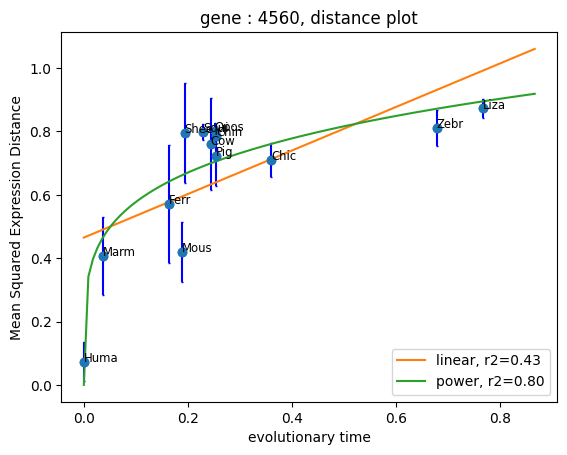

linear fit 0.6829059618923166 0.5462325076443619
power fit 1.0032362207226935 0.17304621226556996


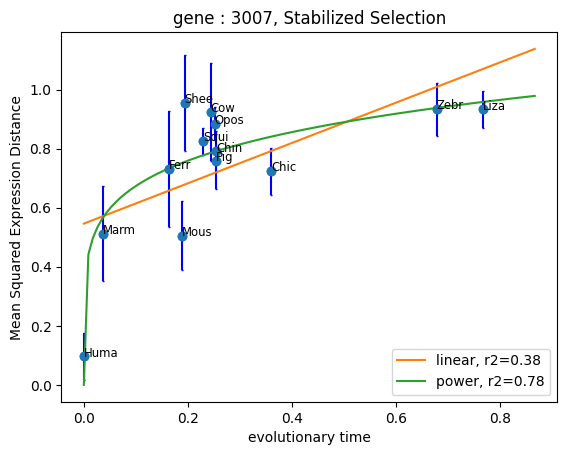

linear fit 0.7054580328567136 0.3118093767689498
power fit 0.8503321053106218 0.3235323866226534


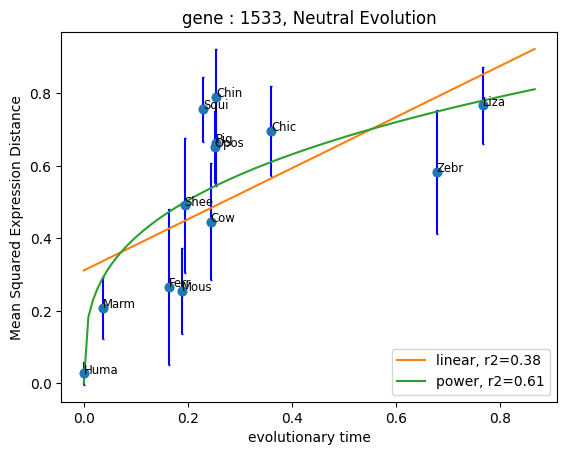

In [129]:
a = dist_plot(residual, species, dist_mat, stat)
a.run()

In [130]:
result = a.compare()
result

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/Users/yunseong-eun/miniconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,gene_name,R2_l,R2_p,m,n,a,k
0,Cdh2,0.000343,0.067161,-0.115372,1.249433,1.350371,1.856657e-02
1,Cep120,0.030874,0.073995,-0.152816,0.226267,0.195848,9.967289e-09
2,Vsx2,0.126676,0.114166,0.036267,0.004229,0.041794,8.649875e-01
3,Heatr5a,0.008085,0.058540,0.060468,0.098837,0.150186,1.318460e-01
4,Abcd4,0.199004,0.155367,0.030802,0.019898,0.044205,2.959807e-01
...,...,...,...,...,...,...,...
4555,Slc30a4,0.011516,0.057412,0.023322,0.036366,0.056661,1.539151e-01
4556,Ndufs3,0.105507,0.393283,0.301529,0.559113,0.752196,7.125414e-02
4557,Celf1,0.028885,0.102148,0.116555,0.165670,0.254150,1.345551e-01
4558,Ap5s1,0.360873,0.356341,0.033061,0.004095,0.034260,7.028289e-01


In [131]:
result.to_csv("/Users/yunseong-eun/Desktop/RGC_modelfit.txt",sep="\t")

In [133]:
pfit = result[result["R2_l"]<result["R2_p"]]["gene_name"]
fdr = np.zeros(len(pfit))
for i, s in enumerate(pfit):
    fdr[i] = stat[stat["gene_name"]==s]["qvalues"].values
fdr

array([2.16670805e-01, 1.00000000e+00, 1.25823079e-01, ...,
       8.60027519e-04, 2.32111456e-04, 2.23960635e-03])

(0.0, 0.2)

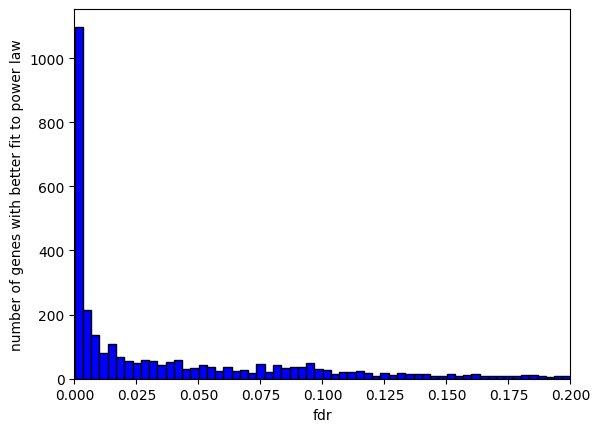

In [137]:
plt.hist(fdr, color = 'blue', edgecolor = 'black', bins=int(300))
plt.xlabel("fdr")
plt.ylabel("number of genes with better fit to power law")
plt.xlim(0,0.2)